# NLP 인공지능 모델을 활용한 항-코로나 약물 후모 물질 검색
# COVID-19 Drug candidate discovery with AI Text mining
References and Dependencies: <br>
1) ScispaCy 논문: https://arxiv.org/pdf/1902.07669.pdf <br>
2) ScispaCy GitHub: https://github.com/allenai/scispacy <br>
3) spaCy 웹싸이트: https://spacy.io/<br>
4) spaCy GitHub: https://github.com/explosion/spaCy<br>
5) BC5CDR corpus(BioCreative V CDR corpus): https://www.ncbi.nlm.nih.gov/research/bionlp/Data/<br>
BC5CDR corpus consists of 1500 PubMed articles with 4409 annotated chemicals, 5818 diseases and 3116 chemical-disease interactions.<br>
6) xyz2mol: https://github.com/jensengroup/xyz2mol<br>
Converts an xyz file to an RDKit mol object<br>

# 1. Setting up computing environment
화학물 구조를 다루려면 SMILES 스트링을 chemical structure로 바꿔주는 rdkit를 설치해야하고 rdkit를 컴파일해서 설치할게 아니라면 conda를 설치해야겠지 근데 conda는 파이썬 버젼에따라 다른 패케이지를 다운받아야하니까 모다? python 버젼을 먼져 확인 사살해보쟝~

In [1]:
# we expect 3.7 on google colab environment
!python --version
!echo $PYTHONPATH

Python 3.7.12
/env/python


## A) Condacolab을 사용하여 설정
Thank you jaime <br>
https://github.com/conda-incubator/condacolab


In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:42
🔁 Restarting kernel...


자 condacolab이 설치되었으니 mamba를 사용하여 rdkit을 설치하여보자

In [3]:
!mamba install -c conda-forge rdkit

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
zipp                     [] (00m:00s) Waiting...
cairo                    [] (00m:00s) Waiting...
importlib-metadata       [] (00m:00s) Waiting...
libwebp-base             [] (00m:00s) Waiting...
libgfortran5             [] (00m:00s) Waiting...
pillow                   [] (00m:00s) Waiting...
reportlab                [] (00m:00s) Validating...
libstdcxx-ng             [] (00m:01s) Decompressing...
gettext                  [] (00m:01s) Waiting...
libtiff                  [] (00m:01s) Waiting...
olefile                  [] (00m:01s) Waiting...
libglib                  [] (00m:01s) Waiting...
libopenblas              [] (00m:01s) Waiting...
libxcb                   [] (00m:01s) Waiting...
python-dateutil          [] (00m:01s) Waiting...
pixman                   [] (00m:01s) Waiting...
pcre                     [] (00m:01s) Waiting...
typing_extensions        [] (00m:01s) Waiting...
sqlalchemy               [] (00m:01s) Waiting...
xorg-libsm              

In [4]:
!which conda
!conda --version
!python --version
!which python

/usr/local/bin/conda
conda 4.9.2
Python 3.7.10
/usr/local/bin/python


내생각엔 원래 런타임을 다시시작해야할건데 잘 안돌아가니까 에러가나면 셀을 다시 한번 돌려줄것

In [1]:
try:
  import rdkit
  from rdkit import Chem
  from rdkit.Chem import Draw
  from rdkit.Chem import AllChem
  from rdkit.Chem.Draw import IPythonConsole
except ImportError:
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run cell again.')
  exit()


     RDKit          2D

 42 45  0  0  0  0  0  0  0  0999 V2000
   13.3753   -0.3600    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   11.8835   -0.5168    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   11.2734   -1.8871    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   12.1551   -3.1006    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.6469   -2.9438    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    9.7816   -2.0439    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    9.1715   -3.4142    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    7.6797   -3.5710    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.7980   -2.3575    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    7.0696   -4.9413    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.5778   -5.0981    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.9513   -6.1548    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
    7.3412   -7.5252    0.0000 P   0  0  0  0  0  0  0  0  0  0  0  0
    6.7311   -8.8955    0

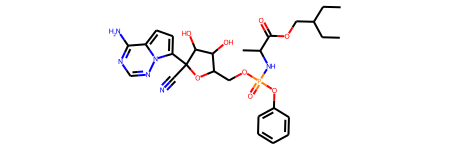

In [2]:
remdesivir = Chem.MolFromSmiles('CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4')
print(Chem.MolToMolBlock(remdesivir))
remdesivir

## B) NLP 설정하기

자 이제 제일 중요한 Pre-training된 NLP 모델을 다운로드 할꺼임<br>
모델은 spaCy NLP 모델을 과학 문서쪽으로 domain adaptation시킨 ScispaCy을 쓸거고 이중에서도 transition-based system인 Named Entity Recognition(NER) 모델 bc5cdr을 쓸건데 이 모델은 1,500개의 PubMed 논문이 가지고 있는 4,409개의 성질이 알려져있는 화학물질 과, 5,818 질병들 그리고 3,116개의 약물질과 질병간의 상호 연관성을 추출해서 학습시켰다고해. 1,500개라니까 논문이 작은거 같겠지만 저거 문장하나하나 그래프 라벨링할려면 내가 박사학위 왜 받았나하는 멘붕의 신세계를 경험할꺼임 ^^; 

In [7]:
# !pip install ipywidgets matplotlib pandas spacy tqdm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bc5cdr_md-0.2.4.tar.gz

     |████████████████████████████████| 70.1 MB 42 kB/s 
  Created wheel for en-ner-bc5cdr-md: filename=en_ner_bc5cdr_md-0.2.4-py3-none-any.whl size=70531465 sha256=37638c60181acb288f735720f97314ece6a57b0e2f2549ee1a90438884fcd684
  Stored in directory: /root/.cache/pip/wheels/7c/f4/2d/75a2d2f28a86df956116d40993f5f81df5f5522665c89230eb
Successfully built en-ner-bc5cdr-md


모델이 다 설치되었으니 xyz좌표계를 rdkit이 읽을 수 있는 포맷으로 바꿔줘야하니까 xyz2mol, py3Dmol, chembl_webresource_client등 cheminfomatics에 필요한 도구들을 설치해줄께 ~ 

In [8]:
%%bash -e
if ! [[ -f ./xyz2mol.py ]]; then
  wget https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
fi

--2021-10-26 04:18:31--  https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23282 (23K) [text/plain]
Saving to: ‘xyz2mol.py’

     0K .......... .......... ..                              100% 28.0M=0.001s

2021-10-26 04:18:31 (28.0 MB/s) - ‘xyz2mol.py’ saved [23282/23282]



유사도 similary %를 지정해주고 약물질과 비슷한 약물질들을 검색하여 가져와 보쟈 그럴려면 ChEMBL 클라이언트를 깔아줘야겠지 -U 는 --upgrade로 최신 버젼을 깔라는거구 ^^<br> https://github.com/chembl/chembl_webresource_client

In [9]:
!pip install py3Dmol
!pip install -U chembl_webresource_client

     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 32.7 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6350 sha256=1ad5719fc3a1d9e4250105be9c38443b7c1d97ef4a7973a5579814aa72be2612
  Stored in directory: /root/.cache/pip/wheels/88/96/68/c2be18e7406804be2e593e1c37845f2dd20ac2ce1381ce40b0
Successfully built easydict


# 2. 파이썬 블랙 매직이지 ^^

/usr/local/lib/python3.7/site-packages/spacy/util.py:766: UserWarning: [W094] Model 'en_ner_bc5cdr_md' (0.2.4) specifies an under-constrained spaCy version requirement: >=2.2.1. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.1.3,<3.2.0
  warnings.warn(warn_msg)

In [86]:
!pip install spacy==2.2.4

In [87]:
import glob
import json
import pandas as pd
import pickle
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from tqdm import tqdm
import en_ner_bc5cdr_md
import os
from collections import Counter
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
import py3Dmol # Amazing library for 3D visualization
from ipywidgets import interact, interactive, fixed
from IPython.display import Image
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
import gc

# 3. Data Curation (Where to store & How to get)
이미 학습된 인공지능 모델을 받아왔기 때문에 Hyperparameter Optimization은 건너뛰고 바로 Feature Engineering으로 넘어가보자. 25만개 논문을 함 읽어 볼까^^

## A) Download data
Allen Institute for AI<br>
https://www.semanticscholar.org/cord19<br>
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html<br>
Data set을 발표한 논문<br>
https://arxiv.org/abs/2004.10706<br>
CORD-19 data-set download<br>
https://cord-19-choi.s3.us-west-1.amazonaws.com/cord-19-jmchoi.tar.gz



GitHub는 리포당 1GB, 파일당 100MB이고 Colab은 107GB, 논문들을 JSON파일 형태로 바꾼 CORD-19 데이터가 총 45GB이고 conda와 rdkit을 모두 설치하면 47GB 정도 나옴, 총 92GB이니까 15GB가 남는군^^, Google Drive mount하는 법이 최선일듯.그리고 파일은 Amazon S3 Bucket에 공유함.<br>
echo * | wc -w #wc -l 혹은 ls가 작동하지 않을때 파일 갯수^^<br>
pmc 약 22만개 pdf는 28만개 총 50만개 논문의 json 파일들 ^^;<br>
https://github.com/kingdavid72/toomany2sub.git<br>
압축하는데 드는시간이 더 비쌈 그냥 압축없이 tar -cvf ^^ <br>



In [20]:
# Download json format papers
# !wget https://cord-19-choi.s3.us-west-1.amazonaws.com/cord-19-jmchoi.tar.gz
# God dam takes foever ^^;

## B) Mount Google drive
이 망할노므 Google Drive 파일이 크면 마운팅해도 바로 안보이고 아예 런타임 다시 시작하고 마운팅까지 다시해야 보이네 ^^;

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!echo ""
!ls /content/drive/MyDrive/CORD-19/class

Mounted at /content/drive

metadata.csv  pmc_json


In [22]:
# !tar -xvf /content/drive/MyDrive/CORD-19/cord-19-jmchoi.tar.gz -C /content/drive/MyDrive/CORD-19

## C) Data Loading into Panda df
우선은 구글드라이브나 Amazon S3 bucket등 에서 다운로드 혹은 마운트된 드라이브로 부터 압축파일을 풀고 데이터를 판다로 로딩함 ~

In [23]:
def doi_to_url(doi):
    if isinstance(doi, float):
        return None
    elif doi.startswith('http'):
        return str(doi)
    elif doi.startswith('doi'):
        return 'https://' + str(doi)
    else:
        return 'https://doi.org/' + str(doi)

Meta data를 로딩해서 Panda 데이터 프레임으로 바꿔줄꺼야, 그리고 url을 위에 함수를 사용해서 doi로 부터 만들어줄거임 ^^

In [24]:
df_meta = pd.read_csv('/content/drive/MyDrive/CORD-19/class/metadata.csv')
df_meta['url'] = df_meta.doi.apply(doi_to_url)
df_meta.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://doi.org/10.1186/1471-2334-1-6,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://doi.org/10.1186/rr14,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://doi.org/10.1186/rr19,NaN


JSON파일들을 로딩해볼거임 약한 25만개 1분정도 걸림 (50만개는 로컬서버가 필요함)

In [25]:
data_path = '/content/drive/MyDrive/CORD-19/class/'
json_files = glob.glob(f'{data_path}/**/**/*.json', recursive=True)
len(json_files)

250281

데이터가 어떤 형태로 생겼는지 봐야겠징

In [57]:
json_files[0:10]

['/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC7112623.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC7737120.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC7805569.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC8021150.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC8117004.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC8310353.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC7827974.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC7409908.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC8055458.xml.json',
 '/content/drive/MyDrive/CORD-19/class/pmc_json/pmc180/PMC8378015.xml.json']

# 4. Cleaning the Data
Data Pre-Processing & Cleaning<br>
어느 인공지능이던간에 제일 중요한 부분이지 ^^ Gabage in gabage out임을 명심하고

pickle이란 method to serialize (convert python objects into byte streams)으로 작은 사이즈로 저장해서 나중에 변환해도 대용량의 data type 에러가 발생하지 않는다. 예로 대용량 파일을 CVS 형태로 저장했다가 불러올경우 필요한 integer들이 String으로 변환되면 찾기 어렵다.<br>
머 여기까지는 대체가능한 이야기지만 ML/AI 모델을 학습시키다가 발생한 엄청나게 큰 object가 있다고 하면 이야기는 달라지지 ㅋㅋㅋ 안그럼 매번 다시 학습해야한다는거 ㅋㅋ 이하는 예제 이다.

In [53]:
data = {
        'a': [1, 2.0, 3, 4+6j],
        'b': ("character string", b"byte string"),
        'c': {None, True, False}
      }

# save data to the file name: data_file
with open('data_file.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# load data from data_file to loaded_data
with open('data_file.pickle', 'rb') as f:
    loaded_data = pickle.load(f)
# Now print loaded_data
print(loaded_data['a'])

[1, 2.0, 3, (4+6j)]


In [48]:
!rm data.pickle
!ls

condacolab_install.log	drive  sample_data  xyz2mol.py


tqdm: progress bar ,br>
json.load(): Json 파일 인코더

In [65]:
def to_covid_json(json_files):
    jsonl = []
    #for file_name in tqdm(json_files):은 로컬서버에서
    for file_name in tqdm(json_files[0:10000]):  
        row = {"doc_id": None, "title": None, "abstract": None, "body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            row['doc_id'] = data['paper_id']
            row['title'] = data['metadata']['title']

            # Take Abstracts
            # abstract_list = [abst['text'] for abst in data['abstract']]
            # abstract = "\n".join(abstract_list)
            # row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n".join(body_list)
            row['body'] = body
            
        jsonl.append(row)
    
    return jsonl
    

def get_data():
    try:
        with open('df_cache.pickle', 'rb') as f:
            df = pickle.load(f)
    except FileNotFoundError:
        df = pd.DataFrame(to_covid_json(json_files))
        with open('df_cache.pickle', 'wb') as f:
            pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)
    return df

df = get_data()
print(df.shape)
df.head(3)

100%|██████████| 10000/10000 [00:31<00:00, 316.48it/s]


(10000, 4)


,doc_id,title,abstract,body
0,PMC7112623,Comparison of the immune responses induced by ...,None,Porcine parvovirus is one of mainly causative ...
1,PMC7737120,One for Everyone: A Study of User Satisfaction...,None,A cross-sectional study was conducted in a lar...
2,PMC7805569,Gasification of refuse-derived fuel from munic...,None,Continuous supply of energy and proper waste d...


이게 또하나의 Cloud 문제인거 ^^; 파일 크기가 커지면 갑자기 파일이 사라지는 현상<br>
df_cache.pickle 이 사라짐 ^^;

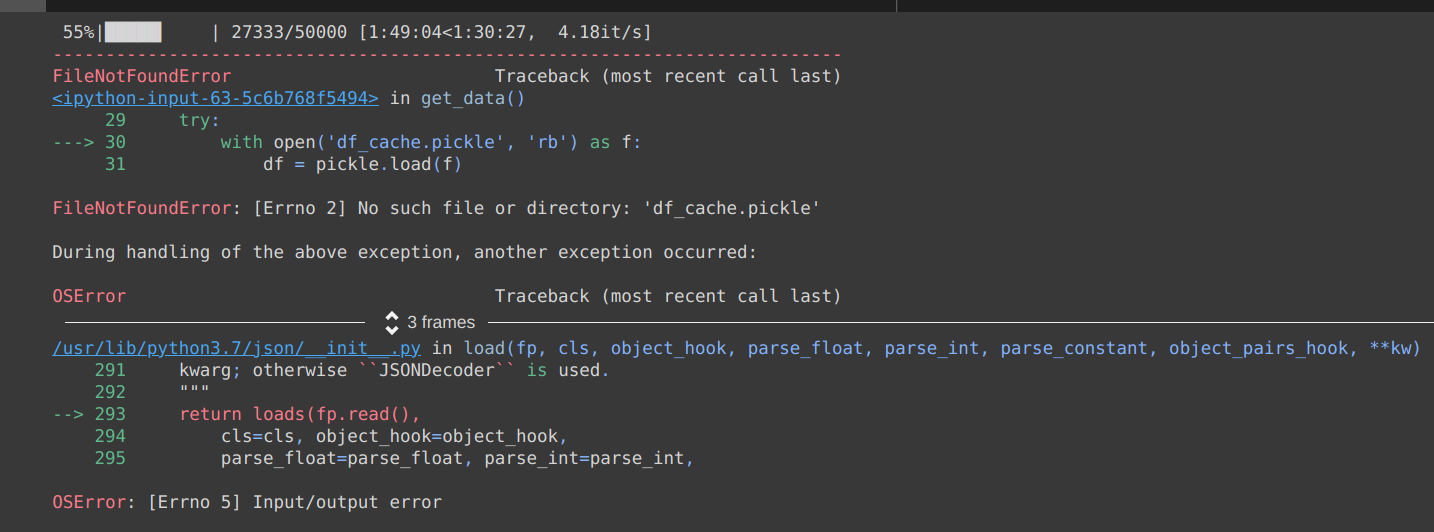

In [67]:
!ls
df.describe()

condacolab_install.log	df_cache.pickle  sample_data
data_file.pickle	drive		 xyz2mol.py


,doc_id,title,abstract,body
count,10000,10000,0,10000
unique,10000,9943,0,9922
top,PMC8359765,Multiple drugs,NaN,None.
freq,1,25,NaN,16


In [68]:
!cp df_cache.pickle /content/drive/MyDrive/CORD-19/class/

자 이제 본격적으로 파일중에 미싱된 칼럼들을 디비보자

In [69]:
def no_title(row):
    return not row.title.strip()

def no_abstract(row):
    return not row.abstract.strip()

def no_body(row):
    return not row.body.strip()

def no_title_abstract_body(row):
    return no_title(row) and no_abstract(row) and no_body(row)

mask = df.apply(no_title_abstract_body, axis=1)
print('Number of articles that have no text data at all:', df.loc[mask].shape[0])

Number of articles that have no text data at all: 0


In [71]:
# insert missing values for empty strings
df.loc[df.apply(no_title, axis=1), 'title'] = None
# df.loc[df.apply(no_abstract, axis=1), 'abstract'] = None
df.loc[df.apply(no_body, axis=1), 'body'] = None
df.head(3)

,doc_id,title,abstract,body
0,PMC7112623,Comparison of the immune responses induced by ...,None,Porcine parvovirus is one of mainly causative ...
1,PMC7737120,One for Everyone: A Study of User Satisfaction...,None,A cross-sectional study was conducted in a lar...
2,PMC7805569,Gasification of refuse-derived fuel from munic...,None,Continuous supply of energy and proper waste d...


메모리를 해방시키기위해 Gabage collection을 수행해줌 하지만 과연 이 시점에서 필요한 걸까? 어차피 12GB에서 6GB사용함

In [73]:
# Gabarge collector
import gc
gc.collect()

1132

# 5. Pre-filter by COVID-19
이부분이 사실은 Bio 전공자가 빛을 발휘할수있는 영역이죰 ^^

해당 키워드들을 정하고 제목과 논문에서 해당 키워드를 포함한 애들만 df로 저장

In [76]:
covid19_names = {
    'COVID19',
    'COVID-19',
    '2019-nCoV',
    '2019-nCoV.',
#     'novel coronavirus',  # too ambiguous, may mean SARS-CoV
    'coronavirus disease 2019',
    'Corona Virus Disease 2019',
    '2019-novel Coronavirus',
    'SARS-CoV-2',
}

def has_covid19(text):
    for name in covid19_names:
        if text and name.lower() in text.lower():
            return True
    return False

df['title_has_covid19'] = df.title.apply(has_covid19)
# df['abstract_has_covid19'] = df.abstract.apply(has_covid19)
df['body_has_covid19'] = df.body.apply(has_covid19)
df_covid19 = df[df.title_has_covid19 | df.body_has_covid19]
print(df_covid19.shape)
df_covid19.head(3)

(5843, 6)


,doc_id,title,abstract,body,title_has_covid19,body_has_covid19
1,PMC7737120,One for Everyone: A Study of User Satisfaction...,None,A cross-sectional study was conducted in a lar...,True,True
2,PMC7805569,Gasification of refuse-derived fuel from munic...,None,Continuous supply of energy and proper waste d...,False,True
3,PMC8021150,COVID-IRS: A novel predictive score for risk o...,None,To develop a new severity score for the predic...,True,True


# 6. Apply ScispaCy Model
en_ner_bc5cdr_md 을 사용해보자. 이모델은 two NER classes: DISEASE and CHEMICAL 를 제공하고 우리가 관심있는건 후자이다.

In [82]:
example_text = "Unfortunately, no drug or vaccine has yet been approved to treat human coronaviruses. Several options can be envisaged to control or prevent emerging infections of 2019-nCoV, including vaccines, monoclonal antibodies, oligonucleotide-based therapies, peptides, interferon therapies and small-molecule drugs. However, new interventions are likely to require months to years to develop. Given the urgency of the 2019-nCoV outbreak, we focus here on the potential to repurpose existing antiviral agents approved or in development for treating infections caused by HIV, hepatitis B virus (HBV), hepatitis C virus (HCV) and influenza1, based on therapeutic experience with two other infections caused by human coronaviruses: severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS).Virally targeted agents. Approved nucleoside analogues (favipiravir and ribavirin) and experimental nucleoside analogues (remdesivir and galidesivir) may have potential against 2019-nCoV. Nucleoside analogues in the form of adenine or guanine derivatives target the RNA-dependent RNA polymerase and block viral RNA synthesis in a broad spectrum of RNA viruses, including human coronaviruses4. Favipiravir (T-705), a guanine analogue approved for influenza treatment, can effectively inhibit the RNA-dependent RNA polymerase of RNA viruses such as influenza, Ebola, yellow fever, chikungunya, norovirus and enterovirus4, and a recent study reported its activity against 2019-nCoV (EC50 = 61.88 μM in Vero E6 cells)5. Patients with 2019-nCoV are being recruited in randomized trials to evaluate the efficacy of favipiravir plus interferon-α (ChiCTR2000029600) and favipiravir plus baloxavir marboxil (an approved influenza inhibitor targeting the cap-dependent endonuclease) (ChiCTR2000029544). Ribavirin is a guanine derivative approved for treating HCV and respiratory syncytial virus (RSV) that has been evaluated in patients with SARS and MERS, but its side effects such as anaemia may be severe at high doses2 and whether it offers sufficient potency against 2019-nCoV is uncertain. Remdesivir (GS-5734) is a phosphoramidate prodrug of an adenine derivative with a chemical structure similar to that of tenofovir alafenamide, an approved HIV reverse transcriptase inhibitor. Remdesivir has broad-spectrum activities against RNA viruses such as MERS and SARS in cell cultures and animal models, and has been tested in a clinical trial for Ebola. A recent study reported that remdesivir inhibited 2019-nCoV (EC50 = 0.77 μM in Vero E6 cells)5, and a US patient with 2019-nCoV recovered after receiving intravenous remdesivir in January6. Two phase III trials were initiated in early February to evaluate intravenous remdesivir (200 mg on day 1 and 100 mg once daily for 9 days) in patients with 2019-nCoV (NCT04252664 and NCT04257656), with estimated completion dates in April 2020. Galidesivir (BCX4430), an adenosine analogue that was originally developed for HCV, is currently in early-stage clinical studies evaluating its safety in healthy subjects and its efficacy against yellow fever, and has shown antiviral activities in preclinical studies against many RNA viruses, including SARS and MERS2."

spacy 모델을 로딩해주고

In [83]:
nlp = en_ner_bc5cdr_md.load()
# nlp = spacy.load('../input/scispacy-model/en_ner_bc5cdr_md-0.2.4/en_ner_bc5cdr_md/en_ner_bc5cdr_md-0.2.4')

예제 text를 처리해서 컬러로 하일라이팅 시켜보자.
spacy displacy는 자주 업데이트되기때문에 예제를 먼저 돌려서 점검해줌<br>
스타일 dep는 워드 토큰간의 dependency를 체크해줌

In [90]:
doc = nlp(example_text)
colors = {
    'CHEMICAL': 'lightpink',
    'DISEASE': 'lightorange',
}

# displacy.render(doc, style='dep', jupyter=True, options={
#     'colors': colors
# })

displacy.render(doc, style='ent', jupyter=True, options={
    'colors': colors
})

이제 예제 tex가 되는걸 확인했으니 아까 만들어 두었던 df_covid19을 돌려볼 차례지

In [91]:
def apply_spacy(texts, nlp):
    docs = []
    for t in texts:
        if t:
            docs.append(nlp(t))
        else:
            docs.append(None)
    return docs

Annotation with spacy

In [92]:
def annotate_with_spacy(df):
    df['title_doc'] = apply_spacy(df.title, nlp)
    df['body_doc'] = apply_spacy(df.body, nlp)
    return df

def get_spacy_df(df):
    try:
        with open('df_spacy_cache.pickle', 'rb') as f:
            df_spacy = pickle.load(f)
    except FileNotFoundError:
        df_spacy = annotate_with_spacy(df)
        with open('df_spacy_cache.pickle', 'wb') as f:
            pickle.dump(df_spacy, f)
    return df_spacy

In [99]:
df_covid19.iloc[:3]

,doc_id,title,abstract,body,title_has_covid19,body_has_covid19,title_doc
1,PMC7737120,One for Everyone: A Study of User Satisfaction...,None,A cross-sectional study was conducted in a lar...,True,True,"(One, for, Everyone, :, A, Study, of, User, Sa..."
2,PMC7805569,Gasification of refuse-derived fuel from munic...,None,Continuous supply of energy and proper waste d...,False,True,"(Gasification, of, refuse-derived, fuel, from,..."
3,PMC8021150,COVID-IRS: A novel predictive score for risk o...,None,To develop a new severity score for the predic...,True,True,"(COVID-IRS, :, A, novel, predictive, score, fo..."


이부분이 Parallel computing 이 필요한 부분, 1만개 조차 안돌아가는 부분임 따라서 천개만 맛배기로 ^^;

In [107]:
# df_spacy = get_spacy_df(df_covid19)
df_spacy = get_spacy_df(df_covid19.iloc[:1000])
df_spacy.iloc[0].body_doc.ents
# df_spacy.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(Facebook,
 WhatsApp,
 801,
 duck-billed,
 duck-billed,
 handkerchiefs,
 guidelines.17,
 employees.18,
 COVID-19,
 self-quarantine,
 acute respiratory syndrome coronavirus 2,
 SARS-CoV-2,
 infection,
 contact.22,24,25
 ,
 Garcia,
 respiratory infections,
 infection,
 procedures,26,27,
 Fillingham,
 infection,
 infection,
 COVID-19,
 Rebmann,
 respiratory infections)

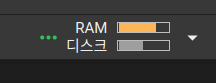

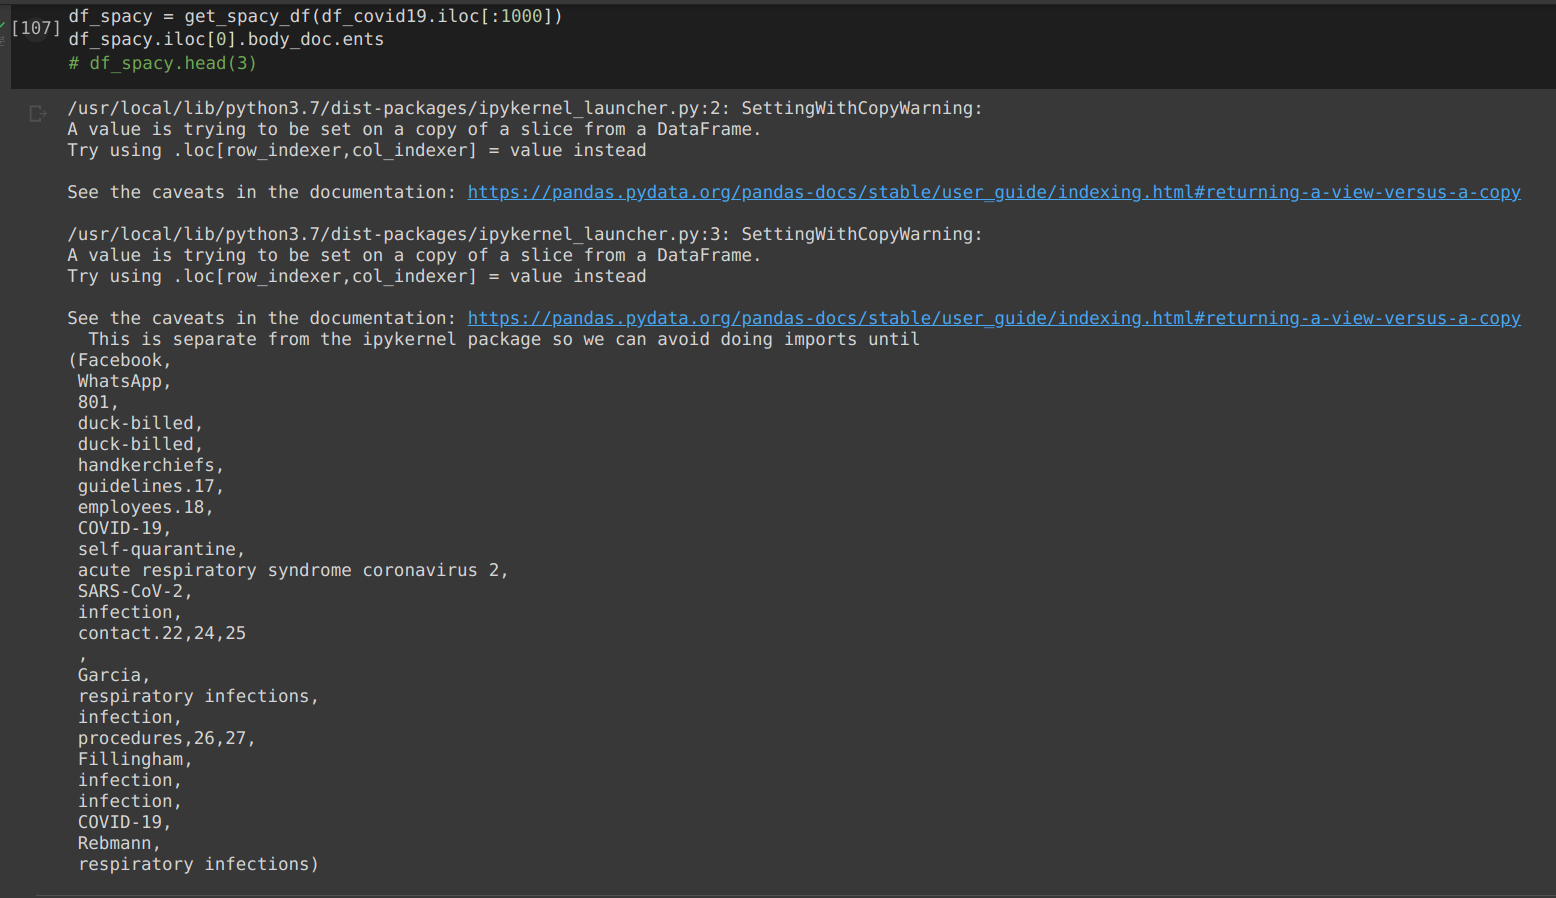

In [111]:
!ls
!cp df_spacy_cache.pickle /content/drive/MyDrive/CORD-19/class/

condacolab_install.log	df_cache.pickle        drive	    xyz2mol.py
data_file.pickle	df_spacy_cache.pickle  sample_data


# 7. Matching relevent tokens like COVID-19, EC50, ...... you name it

In [112]:
trial_indicators = {
    'trial',
    'study',
    'experiment',
    'evaluate',
    'evaluation',
    're-evaluate',
    'report',
    'test',
    'testing',
    'target',
    'data',
    'show',
    'outcome',
    'evaluation',
    'find',
    'agent',
    
}

usage_indicators = {
    'approve',
    'approval',
    'therapeutic',
    'therapy',
    'inhibitory',
    'effect',
    'administer',
    'achieve',
    'improve'
    'alleviate',
    'reduce',
    'antiviral',
    'against',
    'suppress',
    'beneficial',
    'evidence',
    'take',
	'prescribe',
	'treatment',
	'receive',
	'treat',
	'regimen',
	'therapy',
	'use',
	'efficacy',
	'course',
	'drug',
}

idea_indicators = {
    'promising',
    'promise',
    'speculate',
    'believe',
    'would',
    'could',
    'may',
    'possibly',
    'might',
    'should',
    'hypothesize',
    'appear',
    'lack',
    'unclear',
    'need',
} 

matcher = Matcher(nlp.vocab)
for n in trial_indicators:
    matcher.add("trial", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in usage_indicators:
    matcher.add("usage", None, [{'LEMMA': w.lemma_} for w in nlp(n)])
for n in idea_indicators:
    matcher.add("idea", None, [{'LEMMA': w.lemma_} for w in nlp(n)])

example_sent = "Clinical trials (for example, ChiCTR2000029539) have been initiated to test HIV protease inhibitors such as lopinavir and ritonavir in patients infected with 2019-nCoV."
doc = nlp(example_sent)
matches = matcher(doc)
for match_name, start, end in matches:
    print(nlp.vocab.strings[match_name], ':', doc[start:end])

trial : trials
trial : test


In [113]:
def doc_to_matches(doc):
    match_results = {
        'trial': [],
        'usage': [],
        'idea': []
    }
    if not doc:
        return match_results

    matches = matcher(doc)
    for match_id, start, end in matches:
        match_name = nlp.vocab.strings[match_id]
        match_results[match_name].append((start, end))
    return match_results

def get_matches_df(docs):
    matches = []
    for doc in docs:
        matches.append(doc_to_matches(doc))
    df = pd.DataFrame(matches)
    return df
        
df_matches = get_matches_df(df_spacy.body_doc)
df_matches.columns = ['body_trial_matches', 'body_usage_matches', 'body_idea_matches']
df_with_matches = pd.concat([df_spacy.reset_index(drop=True), df_matches], axis=1)
df_with_matches.head(3)

,doc_id,title,abstract,body,title_has_covid19,body_has_covid19,title_doc,body_doc,body_trial_matches,body_usage_matches,body_idea_matches
0,PMC7737120,One for Everyone: A Study of User Satisfaction...,None,A cross-sectional study was conducted in a lar...,True,True,"(One, for, Everyone, :, A, Study, of, User, Sa...","(A, cross-sectional, study, was, conducted, in...","[(2, 3), (29, 30), (32, 33), (343, 344), (454,...","[(54, 55), (59, 60), (100, 101), (107, 108), (...","[(753, 754), (1379, 1380), (2152, 2153), (2203..."
1,PMC7805569,Gasification of refuse-derived fuel from munic...,None,Continuous supply of energy and proper waste d...,False,True,"(Gasification, of, refuse-derived, fuel, from,...","(Continuous, supply, of, energy, and, proper, ...","[(366, 367), (821, 822), (994, 995), (1979, 19...","[(69, 70), (116, 117), (249, 250), (305, 306),...","[(30, 31), (272, 273), (406, 407), (1027, 1028..."
2,PMC8021150,COVID-IRS: A novel predictive score for risk o...,None,To develop a new severity score for the predic...,True,True,"(COVID-IRS, :, A, novel, predictive, score, fo...","(To, develop, a, new, severity, score, for, th...","[(112, 113), (134, 135), (155, 156), (174, 175...","[(186, 187), (230, 231), (241, 242), (252, 253...","[(115, 116), (462, 463), (1558, 1559), (1788, ..."


# 8. Examine Matches

In [117]:
# Check first 3 to see if NLP did the job
print('Example Bodiess', df_with_matches.shape)
for i, row in list(df_with_matches.iterrows())[:3]:
    print('TITLE:', row.title)
    print('\n')
    print(row.body)
    print('\n', '-' * 50, '\n')

Example Bodiess (1000, 11)
TITLE: One for Everyone: A Study of User Satisfaction Among Health-Care Providers Regarding Extended Use of N95 Masks During the COVID-19 Pandemic


A cross-sectional study was conducted in a large tertiary care teaching hospital in New Delhi, and all the employees who were willing to participate were included in the study. The study period was from April 1 to May 31, 2020.
The decision to implement the CDC guidelines for reuse/extended use of N95 masks was taken in April 2020 by the institute administration, and it was decided to issue a set of 5 N95 masks to all HCPs for a period of 20 d. Each mask was supplied in a paper envelope, which was used to store the mask following each use.
During the rollout, a multi-pronged approach was adopted for training the HCPs regarding reuse/extended use of these N95 masks; after the first cycle, feedback was sought from the HCPs regarding the most suitable method for spreading awareness regarding the appropriate use of t

# 9. Extract all the possible drug candidates from body using NLP model
N 숫자 이하로 발생하는 약물들은 걸러주고 블랙리스트를 작성해서 false positive를 줄여줌

Count Frequencies

{'HCQ': 210, 'colchicine': 184, 'carbon': 157, 'hydroxychloroquine': 153, 'CO2': 134, 'vitamin D': 130, 'chloroquine': 128, 'calcium': 123, 'melatonin': 116, 'HIF-1α': 110, 'almond': 106, 'K': 102, 'heparin': 101, 'GSH': 98, 'corticosteroids': 94, 'SM': 92, 'glucose': 87, 'TNF-α': 83, 'ARB': 83, 'IFN-γ': 81, 'NIV': 81, 'EGCG': 81, 'statins': 76, 'dexamethasone': 73, 'GBCAs': 72, 'ADSCs': 70, 'azithromycin': 66, 'MNPs': 65, 'DMPC': 64, 'curcumin': 64, 'angiotensin': 63, 'DIM': 63, 'IPA': 62, 'selenate': 62, 'H2S': 62, 'IL-1β': 61, 'statin': 60, 'Gd': 60, 'kinin': 59, 'hydrogen': 58, 'Met': 58, 'spine': 57, 'PSS': 57, 'HA': 56, 'NO2': 55, 'dutasteride': 54, 'losartan': 53, 'almonds': 53, 'NaCl': 52, 'ATV': 52, 'oseltamivir': 51, 'imatinib': 50, 'IMV': 49, 'silver': 49, 'NF-κB': 47, 'steroids': 47, 'Cefuroxime': 47, 'HBsAg': 47, 'LOPIRITO': 47, '5-HT': 47, 'MBL': 46, 'NET': 46, 'Azithromycin': 45, 'Remdesivir': 45, 'ribavirin': 44, 'lipids': 44, 'ozone': 44, 'glucocorti

<BarContainer object of 96 artists>

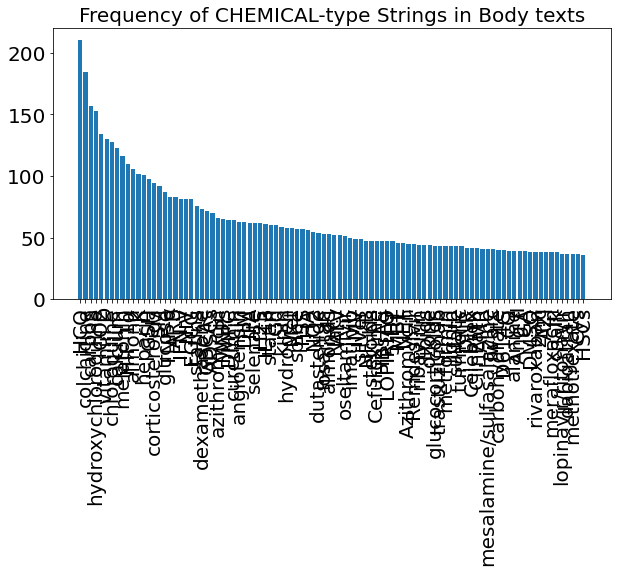

In [136]:
BLACKLIST = {
 'ACE2s',
 '2019-nCoV',
 '95%CI',
 'ACE2-Fc',
 'AMB',
 'AMI',
 'AMK',
 'AOM',
 'AST-045',
 'AST-N041',
 'ATP',
 'BPO3-P',
 'Betacoronavirus',
 'CAP',
 'CAZ',
 'CC',
 'CIP',
 'CP',
 'CLAVE',
 'COVID-2019',
 'CR3022',
 'creatinine', 
 'CTX',
 'CTX-M',
 'CoV-2',
 'DES',
 'DHPG',
 'DIP',
 'E2',
 'ESBL',
 'Enterobacteriaceae',
 'FASTA',
 'FCA',
 'FCS',
 'FOS',
 'GEN',
 'GM',
 'HK',
 'HPDI',
 'IFR',
 'IM',
 'IVA',
 'JA',
 'KLK13',
 'LA',
 'LPV/r',
 'LYM%',
 'La',
 'LcS',
 'Li',
 'MERS-CoV.',
 'MICs',
 'Metapneumovirus',
 'Médecine',
 'NAL',
 'NCP',
 'NG',
 'NLR',
 'NO',
 'NOR',
 'NP',
 'NS7b',
 'OC',
 'OFL',
 'OP',
 'Prefixes',
 'Résumé',
 'S.',
 'SARS-CoV-2',
 'SARS-COV-2',
 'SARS-Cov2',
 'SARS-CoV2',
 'SARS-CoV-2 infection',
 'SARS-CoV-2 infections',
 'SARS-CoV-2 pneumonia',
 'SARS-CoV.',
 'SARS-Cov-2',
 'SARS-related',
 'SGC7901',
 'SHV',
 'SP',
 'Sarbecovirus',
 'Se',
 'TCM',
 'TCR',
 'TCB',
 'TGEV',
 'TOB',
 'TSL-EO',
 'Texte',
 'VME',
 'VP',
 'WeChat',
 'ZJ01',
 '[ST]A',
 'alcohol',
 'amino acid',
 'amino acids',
 'aminoglycosides',
 'bat-SL-CoVZXC21',
 'betacoronavirus',
 'cholesterol',
 'coronavirus',
 'des cas',
 'https://doi.org/10',
 'infector-infectee',
 "l'origine",
 'lactate',
 'lockdowns',
 'na',
 'nucleic acid',
 'nucleic acids',
 'nucleotide',
 'NBCZone',
 'oxygen',
 'quinolones',
 'rinitis',
 'self-imposed',
 'sodium',
 'smoking',
 'β-coronavirus',
 '℃',
 '—',
 '−',
 '\\documentclass[12pt]{minimal}\n\t\t\t\t\\usepackage{amsmath}\n\t\t\t\t\\usepackage{wasysym} \n\t\t\t\t\\usepackage{amsfonts} \n\t\t\t\t\\usepackage{amssymb} \n\t\t\t\t\\usepackage{amsbsy}\n\t\t\t\t\\usepackage{mathrsfs}\n\t\t\t\t\\usepackage{upgreek}\n\t\t\t\t\\setlength{\\oddsidemargin}{-69pt}\n\t\t\t\t',
 'lockdown',
 '}\n\t\t\t\t\\usepackage{amsmath}\n\t\t\t\t\\usepackage{wasysym} \n\t\t\t\t\\usepackage{amsfonts} \n\t\t\t\t\\usepackage{amssymb} \n\t\t\t\t\\usepackage{amsbsy}\n\t\t\t\t\\usepackage{mathrsfs}\n\t\t\t\t\\usepackage{upgreek}\n\t\t\t\t\\setlength{\\oddsidemargin}{-69pt}\n\t\t\t\t',
 'M.2',
 '\\usepackage{amsmath}\n\t\t\t\t\\usepackage{wasysym} \n\t\t\t\t\\usepackage{amsfonts} \n\t\t\t\t\\usepackage{amssymb} \n\t\t\t\t\\usepackage{amsbsy}\n\t\t\t\t\\usepackage{mathrsfs}\n\t\t\t\t\\usepackage{upgreek}\n\t\t\t\t\\setlength{\\oddsidemargin}{-69pt}\n\t\t\t\t',
 '\\documentclass[12pt]{minimal}\n\t\t\t\t\\usepackage{amsmath}\n\t\t\t\t\\usepackage{wasysym} \n\t\t\t\t\\usepackage{amsfonts} \n\t\t\t\t\\usepackage{amssymb} \n\t\t\t\t\\usepackage{amsbsy}\n\t\t\t\t\\usepackage{mathrsfs}\n\t\t\t\t\\usepackage{upgreek}\n\t\t\t\t\\setlength{\\oddsidemargin}{-69pt}\n\t\t\t\t\\begin{document}$$S_1$$\\end{document}S1',
 '\\mathcal',
 '\\mu',
 'k}^{_{j}}}{N_{h',
 '\\alpha',
 'k}^{_{j}}E_{h',
 'k}^{r}}{N_{h',
 'S_{h',
 '}}}',
 '…,N},i≠j',
 '\\documentclass[12pt]{minimal}\n\t\t\t\t\\usepackage{amsmath}\n\t\t\t\t\\usepackage{wasysym} \n\t\t\t\t\\usepackage{amsfonts} \n\t\t\t\t\\usepackage{amssymb} \n\t\t\t\t\\usepackage{amsbsy}\n\t\t\t\t\\usepackage{mathrsfs}\n\t\t\t\t\\usepackage{upgreek}\n\t\t\t\t\\setlength{\\oddsidemargin}{-69pt}\n\t\t\t\t\\begin{document}$$F_1$$\\end{document}F1',
 '\eta }\\digamma',
 'μg/mL',
 'Covid-19',
 'SA',
 'UVA',
 'UA',
 'ROS',
 'Facebook',
 'extract',
 'SARS‐CoV‐2',
 'M.3',
 'anti-SARS-CoV-2',
 'NA',
 'conjugated',
 'COVID-19-related',
 '▸',
 'mJ/cm2',
 'non-COVID-19',
 'self-isolate',
 'Wuhan-Hu-1',
 'F(1',
 'pre-COVID-19',
 'ruxolitinib'}


def count_chemical_ents(df):
    ent_str = []
    for i, row in df.iterrows():
        if row.body_doc:            
            for ent in row.body_doc.ents:
                if ent.label_ == 'CHEMICAL':
                    ent_str.append(row.body_doc[ent.start:ent.end].text)
            
    # Play with filter counter 8~20 maybe
    filtered = [e for e in Counter(ent_str).most_common() if e[1] > 35 and e[0] not in BLACKLIST]
    return dict(filtered)

counts = count_chemical_ents(df_with_matches)
print('Count Frequencies\n')
print(counts)

plt.figure(figsize=(10,5))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xticks(rotation=90)
plt.title('Frequency of CHEMICAL-type Strings in Body texts', fontsize=20)
plt.bar(counts.keys(), counts.values())

#10. Simple interactive visulizer to see the text
실제 필터링해야할지 판단이 안서면 문장을 보면서 필터를 정하면 됨

In [137]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.core.display import HTML

HTML_WRAPPER = """<div style="overflow-x: auto; border: 1px solid #e6e9ef; border-radius: 0.25rem; padding: 1rem; margin-bottom: 2.5rem">{}</div>"""
BEGIN_ENTITY = """<mark class="entity" style="background: lightpink; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY = """</mark>"""

def match_to_concordance_html(match, doc, window_size=15):
    _, start, end = match
    concordance_start = max(start - window_size, 0)
    concordance_end = min(end + window_size, len(doc))
    return doc[concordance_start:start].text + BEGIN_ENTITY + doc[start:end].text + END_ENTITY + doc[end:concordance_end].text + '</br></br>'

@interact_manual
def show_articles_more_than(column='body_doc', query='Remdesivir'):
    matcher = Matcher(nlp.vocab)
    matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(query)])
    result = []
    html_str = ''
    for doc in df_with_matches[column]:
        if not doc:
            continue
        matches = matcher(doc)
        for match in matches:
            html_str += match_to_concordance_html(match, doc)
    return display(HTML(HTML_WRAPPER.format(html_str + ''))) ##

interactive(children=(Text(value='body_doc', description='column'), Text(value='Remdesivir', description='quer…

#11. Organise matches by Drugs/Therapeutics
drug is in an idea stage (e.g. 'darunavir could be useful against COVID-19')
drug is in a trial stage (e.g. 'lopinavir is currently being trialled')
drug is in usage stage (e.g. 'patients are being treated with ritonavir')
Context Search를 진행하여 화학물을 가능성있는 약물후보로 링크된넘을 찾아줌

In [138]:
def doc_id_to_link(doc_id, df_meta, df_data):
    rows = df_meta[df_meta.sha == doc_id]
    if rows.empty:
        return 'UNKNOWN URL AND TITLE'
    url = rows.iloc[0].url
    title = rows.iloc[0].title
    if url and title:
        return '<a href="{}">'.format(url) + title + '</a>'
    elif title:
        return title
    elif url:
        return '<a href="{}">'.format(url) + 'UNKNOWN TITLE' + '</a>'
    else:
        return 'UNKNOWN URL AND TITLE'

def chemical_df(chemicals, df_data, df_meta):
    rows = []    
    for chem in chemicals:
        chem_row = {
            'chemical_name': chem,
            'chemical': [],
            'trials': [],
            'usages': [],
            'ideas': []
        }
        matcher = Matcher(nlp.vocab)
        matcher.add("query", None, [{'LEMMA': w.lemma_} for w in nlp(chem)])
        for i, row in df_data.iterrows():
            chem_matches = matcher(row.body_doc)
            for chem_match in chem_matches:
                chem_row['chemical'].append((row.doc_id, chem_match[1], chem_match[2]))
                for trial_match in row.body_trial_matches:
                    if abs(trial_match[1] - chem_match[1]) < 15:
                        chem_row['trials'].append((row.doc_id, trial_match[0], trial_match[1]))
                for usage_match in row.body_usage_matches:
                    if abs(usage_match[1] - chem_match[1]) < 15:
                        chem_row['usages'].append((row.doc_id, usage_match[0], usage_match[1]))
                for idea_match in row.body_idea_matches:
                    if abs(idea_match[1] - chem_match[1]) < 15:
                        chem_row['ideas'].append((row.doc_id, idea_match[0], idea_match[1]))
        rows.append(chem_row)
    return pd.DataFrame(rows)
        
    
df_chemical = chemical_df(list(counts.keys()), df_with_matches, df_meta)
df_chemical.head(3)

,chemical_name,chemical,trials,usages,ideas
0,HCQ,"[(PMC8445882, 500, 501)]",[],[],[]
1,colchicine,"[(PMC8409160, 1936, 1937), (PMC7197570, 192, 1...","[(PMC7197570, 250, 251), (PMC7197570, 304, 305...","[(PMC8409160, 1924, 1925), (PMC7197570, 178, 1...","[(PMC7197570, 302, 303), (PMC7197570, 362, 363..."
2,carbon,"[(PMC7805569, 1503, 1504), (PMC7805569, 1513, ...","[(PMC7805569, 2447, 2448), (PMC7805569, 2471, ...","[(PMC7805569, 1511, 1512), (PMC7805569, 1511, ...","[(PMC8424413, 8993, 8994), (PMC7256513, 6212, ..."


이제 context가 다됐으면 텍스트 하일라이팅을 통하여 context matching이 잘되었는지 확인하고

In [140]:
LABEL_TO_COLOUR = {
    'chemical': 'lightorange',
    'trials': 'lightpink',
    'usages': 'lightgreen',
    'ideas': 'lightblue'
}
BEGIN_ENTITY = """<mark class="entity" style="background: {}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">"""
END_ENTITY_WITH_SUBSCRIPT = """<span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">{}</span>\n</mark>"""

def get_ents_by_doc_id(row):
    contexts={'chemical', 'trials', 'usages', 'ideas'}
    ents_by_doc_id = {}
    for c in contexts:
        for doc_id, start, end in row[c]:
            entry = (start, end, c)
            if doc_id not in ents_by_doc_id:
                ents_by_doc_id[doc_id] = [entry]
            else:
                ents_by_doc_id[doc_id].append(entry)
    return ents_by_doc_id

@interact
def show_articles_for_chemical(chemical=list(counts.keys())):
    row = df_chemical[df_chemical['chemical_name'] == chemical].iloc[0]
    ents_by_doc_id = get_ents_by_doc_id(row)
    html = ''
    for doc_id, ents in ents_by_doc_id.items():
        doc = df_with_matches[df_with_matches.doc_id == doc_id].iloc[0].body_doc
        sorted_ents = sorted(set(ents))
        doc_html = doc_id_to_link(doc_id, df_meta, df_covid19) + '</br></br>' 
        prev_end = 0
        for start, end, label in sorted_ents:
            doc_html += doc[prev_end:start].text
            doc_html += ' ' + BEGIN_ENTITY.format(LABEL_TO_COLOUR[label]) + doc[start:end].text + END_ENTITY_WITH_SUBSCRIPT.format(label) + ' '
            prev_end = end
        doc_html += doc[end:].text + '</br></br>'
        html+=doc_html
        

    return display(HTML(html))

interactive(children=(Dropdown(description='chemical', options=('HCQ', 'colchicine', 'carbon', 'hydroxychloroq…

# 12. PCA and K-mean clustering of candiate molecules
자 이제 후모들을 모아서 PCA로 dimentionality reduction을 해주고 K-mean clustering도 진행해야하지만 아직은 데이터가 지저분하고 양도 많치않음 ^^;

In [141]:
# function to draw the molecule
def drawit(m,p,confId=-1):
    mb = Chem.MolToMolBlock(m,confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
p = py3Dmol.view(width=400,height=400)

In [142]:
# get the top drugs most mencioned
listchemicals = df_chemical.chemical_name.replace('lopinavir/ritonavir', 'lopinavir').head(25)
listchemicals

0                    HCQ
1             colchicine
2                 carbon
3     hydroxychloroquine
4                    CO2
5              vitamin D
6            chloroquine
7                calcium
8              melatonin
9                 HIF-1α
10                almond
11                     K
12               heparin
13                   GSH
14       corticosteroids
15                    SM
16               glucose
17                 TNF-α
18                   ARB
19                 IFN-γ
20                   NIV
21                  EGCG
22               statins
23         dexamethasone
24                 GBCAs
Name: chemical_name, dtype: object

자 이제 클러스터를 만들어 볼건데 ~

In [143]:
# Create clusters
listMols2 = []
listValids = []

for i in range(len(listchemicals)):
    try:
        productName = listchemicals[i]
        
        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        listMols2.append(m)
        listValids.append(productName)
      
    except Exception as e:
        print(f'\nSorry, impossible to create structure for {productName}.')
        
        
# generate fingeprints: Morgan fingerprint with radius 2
n_dimensions = 300
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, n_dimensions) for m in listMols2]
# Convert to numpy array
np_fps = np.asarray(fps)

############# PCA decomposition (n=3)  #######################
centers = [[1, 1], [-1, -1], [1, -1]]
X = np_fps
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
df2 = pd.DataFrame(X ,columns=['principal_component_1','principal_component_2','principal_component_3'])
df2['names'] = pd.DataFrame(listValids)

############# Kmeans clusters  #######################
kmeansmodel = KMeans(n_clusters=8).fit(df2[df2.columns[0:3]])
labelKmeans = kmeansmodel.labels_.astype(float)
df2['cluster'] = labelKmeans


Sorry, impossible to create structure for almond.

Sorry, impossible to create structure for K.

Sorry, impossible to create structure for heparin.

Sorry, impossible to create structure for SM.

Sorry, impossible to create structure for TNF-α.

Sorry, impossible to create structure for GBCAs.


In [144]:
# Remove duplicated compounds
df2 = df2.drop_duplicates(subset=['principal_component_1','principal_component_2','principal_component_3'])
df2.sort_values(by=['cluster'])

,principal_component_1,principal_component_2,principal_component_3,names,cluster
2,0.917543,-1.343364,-2.084137,carbon,0.0
4,0.663576,-1.331156,-2.317512,CO2,0.0
7,0.845121,-1.338861,-2.278922,calcium,0.0
12,0.409476,-1.983748,-1.024125,glucose,0.0
1,-1.312948,0.326669,-0.985618,colchicine,1.0
16,-1.508146,-0.969661,-0.471881,EGCG,1.0
8,-0.682597,0.263326,-0.937235,melatonin,1.0
14,-0.631802,0.413712,-0.494502,IFN-γ,1.0
0,4.626975,0.914661,1.791162,HCQ,2.0
6,4.313132,1.013218,1.092174,chloroquine,2.0


In [145]:
# Gabarge collector to liberate memory
gc.collect()

407

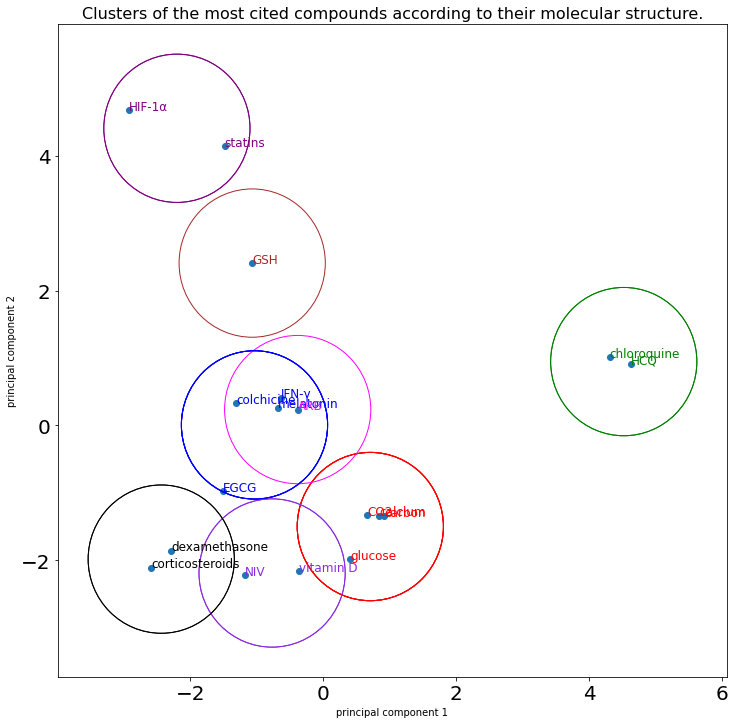

In [146]:
############# Scatter plot  #######################
import matplotlib.patches as mpatches

centroids  = kmeansmodel.cluster_centers_

def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

xs = df2.principal_component_1
ys = df2.principal_component_2
names = df2.names
cluster = df2.cluster
ax.scatter(xs, ys)
radius = 1.1

for x,y,names,cluster in zip(xs,ys,names,cluster):
    label = names
    if cluster == 0:
        ax.text(x, y, label, fontsize=12, color='red')
        art = mpatches.Circle(centroids[0],radius, edgecolor='r',fill=False)
        ax.add_patch(art)
    if cluster == 1:
        ax.text(x, y, label,fontsize=12, color='blue')
        art = mpatches.Circle(centroids[1],radius, edgecolor='blue',fill=False)
        ax.add_patch(art)        
    if cluster == 2:
        ax.text(x, y, label, fontsize=12, color='green')
        art = mpatches.Circle(centroids[2],radius, edgecolor='green',fill=False)
        ax.add_patch(art)        
    if cluster == 3:
        ax.text(x, y, label, fontsize=12, color='black') 
        art = mpatches.Circle(centroids[3],radius, edgecolor='black',fill=False)
        ax.add_patch(art)        
    if cluster == 4:
        ax.text(x, y, label, fontsize=12, color='purple')
        art = mpatches.Circle(centroids[4],radius, edgecolor='purple',fill=False)
        ax.add_patch(art)        
    if cluster == 5:
        ax.text(x, y, label, fontsize=12, color='blueviolet') 
        art = mpatches.Circle(centroids[5],radius, edgecolor='blueviolet',fill=False)
        ax.add_patch(art)        
    if cluster == 6:
        ax.text(x, y, label, fontsize=12, color='brown') 
        art = mpatches.Circle(centroids[6],radius, edgecolor='brown',fill=False)
        ax.add_patch(art)        
    if cluster == 7:
        ax.text(x, y, label, fontsize=12, color='magenta')  
        art = mpatches.Circle(centroids[7],radius, edgecolor='magenta',fill=False)
        ax.add_patch(art)        
    
      

ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.title('Clusters of the most cited compounds according to their molecular structure.', loc='center', pad=None, fontSize=16)
plt.show()

# 13.  Performing molecular similarity search on ChEMBL database
여기서 부터는 진정한 유기화학/약학의 분야이고 컴터랑 접목되면 Cheminfomatics라고 불리움

In [156]:
# get the top drugs most mencioned
listchemicals = listchemicals.head(6)
listchemicals

0                   HCQ
1            colchicine
2                carbon
3    hydroxychloroquine
4                   CO2
5             vitamin D
Name: chemical_name, dtype: object

In [174]:
percentSimilarity = 50

def print_structures(productName):
    try:

        print('\n..................................................................................')
        print(f'\nStructure of {productName}\n')

        ################## Find the molecular structure in Chembl database ###########################

        # Initiate Chembl database client
        molecule = new_client.molecule
        # get the moelcule id
        molecule_chembl_id = molecule.search(productName)[0]['molecule_chembl_id']
        res = molecule.get(molecule_chembl_id)
        # return smile format molecular structure
        smileStruct = res['molecule_structures']['canonical_smiles']
        # converto to mol format using RDKIT library
        m = Chem.MolFromSmiles(smileStruct)
        m = Chem.AddHs(m)
        # create the molecule image
        AllChem.EmbedMultipleConfs(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
        interact(drawit, m=fixed(m),p=fixed(p));

        ############ Find similar molecules in Chembl database ###################################### 
        print(f'\nMolecules that have at least {percentSimilarity}% similarity with {productName}\n')

        similarity = new_client.similarity
        similar = similarity.filter(chembl_id=molecule_chembl_id, similarity=percentSimilarity)

        list_mols=[]
        list_ref_name = []

        for i in range(len(similar)):

            ref_name = (similar[i]['pref_name'])
            if ref_name is None:
                ref_name = similar[i]['molecule_chembl_id']
    #             print(ref_name)
            smileStruct = Chem.MolFromSmiles(similar[i]['molecule_structures']['canonical_smiles'])
            list_mols.append(smileStruct)
            list_ref_name.append(ref_name)

        ms = [x for x in list_mols if x is not None]

        for m in ms: tmp=AllChem.Compute2DCoords(m)

        img=Draw.MolsToGridImage(ms, molsPerRow=3,subImgSize=(200,200),legends=[x for x in list_ref_name])
        
        fileName = 'related_' + productName + '.png'
        img.save(fileName)
        image = cv2.imread(fileName)        

        plt.figure(figsize=(20, 80))
        plt.ticklabel_format(style = 'plain')
        plt.axis('off')
        plt.imshow(image)
        plt.show()

    except Exception as e:
        print('\nSorry, structure not found in Chembl database.')

In [175]:
print(listchemicals[3])
print_structures(listchemicals[3])

hydroxychloroquine

..................................................................................

Structure of hydroxychloroquine



interactive(children=(IntSlider(value=-1, description='confId', max=1, min=-3), Output()), _dom_classes=('widg…


Molecules that have at least 50% similarity with hydroxychloroquine


Sorry, structure not found in Chembl database.


In [176]:
sim = new_client.similarity 
similar_remdesivir_100 = sim.filter(smiles="CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4", similarity=100)
similar_remdesivir_65 = sim.filter(smiles="CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4", similarity=65) 
num_similar_100 = len(similar_remdesivir_100)
num_similar_65 = len(similar_remdesivir_65)
print(f"{num_similar_100} moleucles are retrived fron ChEMBL Database with 100% similarity ✨🍰✨")
print(f"{num_similar_65} moleucles are retrived fron ChEMBL Database with 65% similarity ✨🍰✨")

4 moleucles are retrived fron ChEMBL Database with 100% similarity ✨🍰✨
27 moleucles are retrived fron ChEMBL Database with 65% similarity ✨🍰✨


# 14. Ligand based QSAR or Structure-based in_silico_screening  
여기서 부터는 진정한 Structural infomatics 혹은 MOA (Mode of Action)을 찾는 작업이 동반됨

# 14.5 organic synthesis and CMC of API
유기합성의 신세계를 경험 ~ Chemistry Manufacturing Control

# 15. In-vitro assay
여기서 부터는 Biochemistry 분야이고 Enzyme kinetics로 Inhibition mode를 분석하게됨 

# 16. Cell Biology
여기서 부터는 진정한 바이오 영역이고 Caco-2 cell등 다양한 세포들을 가지고 세포 투과도 독성등을 보게됨

# 17. Mouse Model
ADME, PK/PD등을 보게되는 과정임 잘하면 IND 파일링 가는거고 ^^

# 18. Clinical Trials
대망의 임상, 의사선생님 간호사 클리니컬 코디들과 통계학자 그리고 돈없는 대학원생들의 천국이지욤

# 99. To Keep connected
구글이여 제발 나의 런타임을 종료시키지 말아다오

In [109]:
while True:pass

KeyboardInterrupt: ignored